<a href="https://colab.research.google.com/github/dcolinmorgan/test/blob/master/LTRC_deg_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os,glob,gc
import pandas as pd
import numpy as np
from psutil import *
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import math,keras,time
import tensorflow as tf
# import cupy as cp

timestr = time.strftime("%Y%m%d-%H%M")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',names=['TF','genes'])
##CASE
# np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case',tdata)
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_case.npy'))
# tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcase.npy'))
# tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcase_ages.txt',header=None)[0]
# tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# tdata=tdata.T

# #CONTROL
# # np.save('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control',tdata)
# # tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LARGECOPD_time_control.npy'))
tdata=pd.DataFrame(np.load('drive/My Drive/LARGE_PANDA/LTRCcontrol.npy'))
tdata.columns=pd.read_csv('drive/My Drive/LARGE_PANDA/LTRCcontrol_ages.txt',header=None)[0]
# # tdata_ages[0]
# tdata.index=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
# links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None)#[0]
links=pd.read_csv('drive/My Drive/LARGE_PANDA/LARGECOPD_links.txt',header=None,names=['TF','gene'])


# t2data=tdata.iloc[:,0:100]
# t2data=tdata[np.abs(np.mean(tdata.iloc[:,10:20],axis=1) - np.mean(tdata.iloc[:,30:40],axis=1))>1.5]

# print(t2data.shape)
# del tdata
# tdata=pd.DataFrame()


In [ ]:
# t2data=t2data.T
# t2data=t2data.reset_index()
# del t2data[0]
# t2data=t2data.T

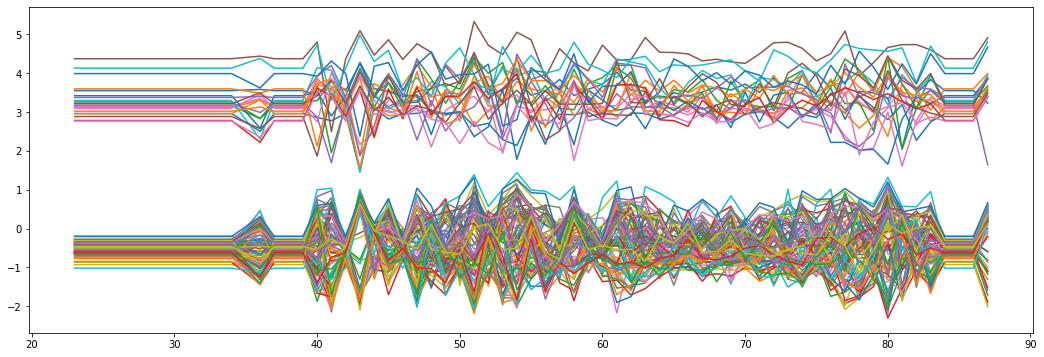

In [ ]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[:,1:100])

In [ ]:
tdata.index=links.TF
cont_TF_sum=tdata.groupby(['TF']).sum()
# cont_TF_sum

In [ ]:
tdata.index=links.gene
cont_gene_sum=tdata.groupby(['gene']).sum()
# cont_gene_sum

In [ ]:
from scipy.stats import zscore
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import DateOffset

from keras.preprocessing import timeseries_dataset_from_array
from keras.utils import plot_model
from keras.models import load_model

from keras import Sequential
from keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda,Dropout,Activation#,CuDNNLSTM
from keras.callbacks import EarlyStopping, LearningRateScheduler,ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
[np.linalg.matrix_rank(tdata),np.linalg.cond(tdata)]

[46, 1.0939657165114198e+22]

In [ ]:
tdata=tdata.T.iloc[:,1:10000]
# Create correlation matrix
corr_matrix = tdata.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

# Drop features 
tdata.drop(to_drop, axis=1, inplace=True)
# tdata=tdata.T

##prepare time steps

In [ ]:
tdata.shape

(8783160, 57)

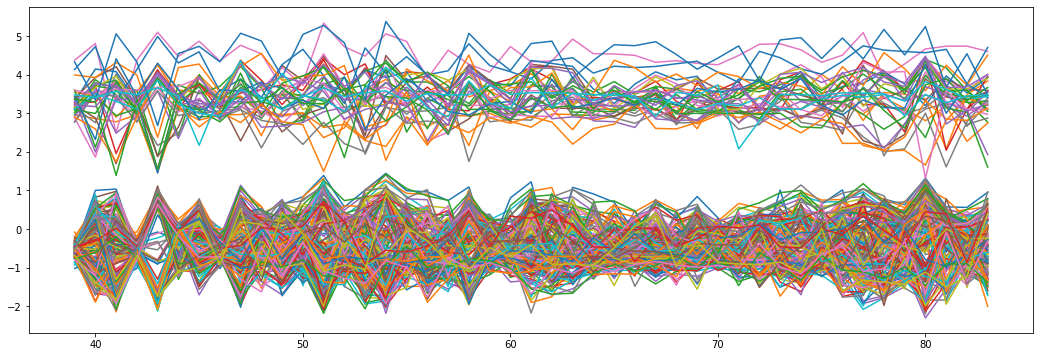

In [ ]:
plt.figure(figsize=(18, 6))
w=plt.plot(tdata.T.iloc[8:53,0:200])

In [ ]:
# t2data=pd.DataFrame(t2data.T)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
t2data = scaler.fit_transform(tdata.T.iloc[8:53,0:20000])#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))

# X_std = (tdata - tdata.min(axis=0)) / (tdata.max(axis=0) - tdata.min(axis=0))
# X_scaled = X_std * (1 - 0) + 0

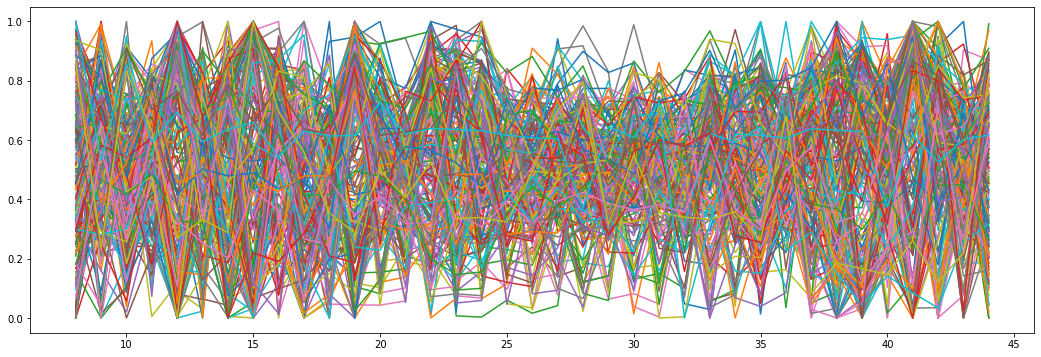

In [ ]:
plt.figure(figsize=(18, 6))
w=plt.plot(pd.DataFrame(t2data).iloc[8:53,0:200])

In [ ]:
t2data=t2data[np.abs(np.mean(t2data.T.iloc[:,10:20],axis=1) - np.mean(t2data.T.iloc[:,30:40],axis=1))>.4]
t2data=t2data
t2data.shape


In [ ]:
t3data=t2data.T.iloc[8:53,:].groupby(np.arange(len(t2data.T.iloc[8:53,:].columns))//2, axis=1).mean()

In [ ]:
# t3data=t3data.T

In [ ]:
plt.figure(figsize=(18, 6))
w=plt.plot(t3data.iloc[:,0:5])

In [ ]:
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# t2data = scaler.fit_transform(np.transpose(tdata.iloc[:,:]))#cont_gene_sum.iloc[:,10:50])) #r2data.iloc[:,10:50]))
# split into train and test sets

# t2data=np.array(tdata.T.iloc[8:53,0:10000])

train_size = int(len(t2data) * 0.68)
test_size = len(t2data) - train_size
train, test = t2data[0:train_size,:], t2data[train_size:(train_size+test_size),:]
print(len(train),len(test))

30 15


In [ ]:
look_back=5
training_sequence = TimeseriesGenerator((train), (train), length=look_back,batch_size=look_back)
validation_sequence = TimeseriesGenerator((test), (test),  length=look_back,batch_size=look_back)
print(training_sequence.data.shape,validation_sequence.data.shape)

(30, 20000) (15, 20000)


In [ ]:
model = Sequential()
## graph neural network then (lower D space) to LSTM (neighborhood) NOT conv1d (spatial from images)
initializer=tf.keras.initializers.Orthogonal()
model.add(LSTM(1024, input_shape=(look_back, training_sequence.data.shape[1]),return_sequences=True, kernel_initializer=initializer)) #orthoganal initialization for weight, he  # 5 time steps and 32831 features/genes
# model.add(Activation('relu'))
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add((LSTM(512,activation='relu',return_sequences=True))),
model.add(Bidirectional(LSTM(512,activation='relu',return_sequences=True))),
# model.add(Activation('relu'))
model.add(Bidirectional(LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),
model.add((LSTM(256,activation='relu',return_sequences=True))),

# model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True))),
model.add((LSTM(128,activation='relu',return_sequences=True))),

model.add((LSTM(64,activation='relu'))),
# model.add(Dropout(0.15))
# model.add((LSTM(32,activation='relu'))),
model.add(Dense(training_sequence.data.shape[1]))

model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])
# print(model.summary())


In [ ]:
callbacks = [
    LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20)),
    EarlyStopping(patience=5, verbose=1),#monitor='loss'),
    # ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
tf.config.run_functions_eagerly(False) ## steps per epoch are total time steps / look_back, ie 40 year / 5 lookback

history =model.fit(training_sequence, epochs=100, callbacks=callbacks,validation_data=validation_sequence)

In [ ]:
model.save('drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_'+timestr+'.h')
plot_model(model, to_file='drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_'+timestr+'.png', show_shapes=True)
Image(filename='drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_'+timestr+'.png')

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/LARGE_PANDA/model_output/Cont_geneoutdegree_20210414-2043.h')
model.compile(loss='mse',
              experimental_steps_per_execution = 50,
              optimizer='adam',
              metrics=['mse'])

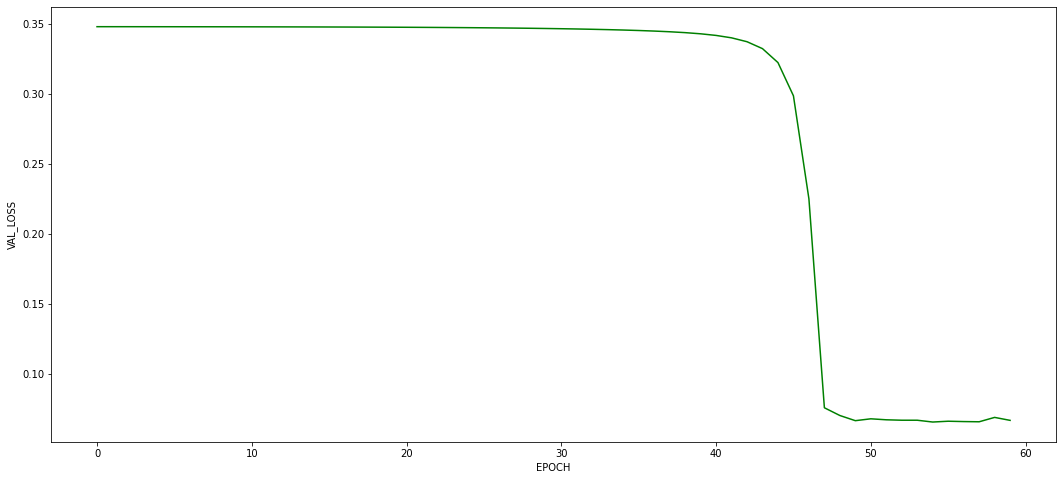

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.figure(figsize=(18, 8))
plt.plot(hist['epoch'],hist['val_loss'], color= 'green')
# plt.plot(loss, color='red')
# plt.title("Close price of stocks sold")
plt.xlabel("EPOCH")
plt.ylabel("VAL_LOSS")
plt.show()

In [ ]:
# # make predictions
# # trainPredict = model.predict(testX)
# trainPredict = model.predict(t2data[30:].reshape(1,t2data[30:].shape[0],t2data[30:].shape[1]))

# # testPredict = model.predict(testY)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# # trainY = scaler.inverse_transform(trainY)
# # testPredict = scaler.inverse_transform(testPredict)
# # testY = scaler.inverse_transform(testY)
# # calculate root mean squared error
# # trainScore = math.sqrt(mean_squared_error(testX, trainPredict))
# # print('Train Score: %.2f RMSE' % (trainScore))
# # testScore = math.sqrt(mean_squared_error(testY[0], testPredict))
# # print('Test Score: %.2f RMSE' % (testScore))

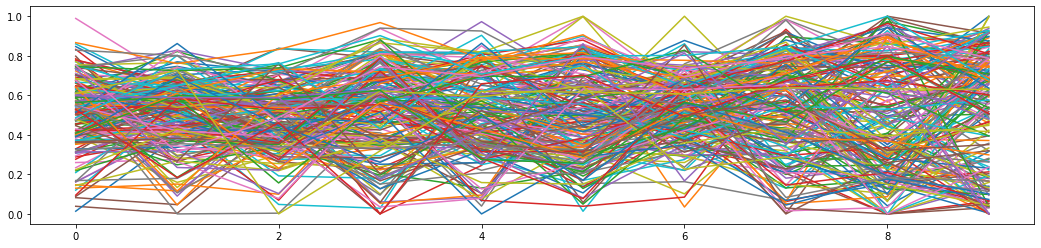

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(t2data[30:40,1:200])#.iloc[0:42,0:9])

In [ ]:
t2data[30:40]

array([[0.54888143, 0.67754256, 0.5239187 , ..., 0.5201359 , 0.1308137 ,
        0.40928205],
       [0.42791263, 0.74643634, 0.40515607, ..., 0.4977953 , 0.41989044,
        0.48991231],
       [0.43701118, 0.65048724, 0.38392455, ..., 0.71006897, 0.51729506,
        0.42061002],
       ...,
       [0.41849401, 0.6965497 , 0.37390675, ..., 0.17487787, 0.14787951,
        0.24682658],
       [0.69882113, 0.33599329, 0.73841878, ..., 0.27750358, 0.169835  ,
        0.15776586],
       [0.69457239, 0.66382125, 0.45855746, ..., 0.67272397, 0.14388294,
        0.16827646]])

In [ ]:
batch =np.expand_dims(t2data[30:40],axis=0)
print(batch)
model.predict(batch)

[[[0.54888143 0.67754256 0.5239187  ... 0.5201359  0.1308137  0.40928205]
  [0.42791263 0.74643634 0.40515607 ... 0.4977953  0.41989044 0.48991231]
  [0.43701118 0.65048724 0.38392455 ... 0.71006897 0.51729506 0.42061002]
  ...
  [0.41849401 0.6965497  0.37390675 ... 0.17487787 0.14787951 0.24682658]
  [0.69882113 0.33599329 0.73841878 ... 0.27750358 0.169835   0.15776586]
  [0.69457239 0.66382125 0.45855746 ... 0.67272397 0.14388294 0.16827646]]]


array([[ 91.21242, 113.30685,  78.41656, ...,  92.98983,  78.77581,
         77.54819]], dtype=float32)

In [ ]:
batch =np.expand_dims(t2data[30:40],axis=0)#.reshape(1,t2data[30:40].shape[0],t2data[30:40].shape[1]))
cc=batch.shape[1]
pred_list = []
# batch=batch.T
for i in range(cc):
  # print(batch[0,1:,:])
  pred_list.append(model.predict(batch))    #[0])  ## comment T then uncomment
  batch = np.append(batch[0,1:,:],pred_list[i],axis=0)
  # print([batch.shape,pred_list[i].T.shape])
  # batch=batch.T
  # print(pred_list[i])
  # print(pd.DataFrame(batch))
  batch = np.expand_dims(batch, 0)
  # print([i,batch.shape])
# print(pd.DataFrame(np.squeeze(pred_list)))

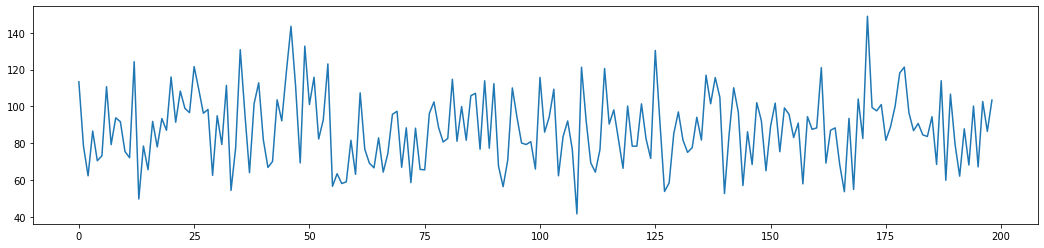

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(batch[0,1,1:200])

In [ ]:
batch

array([[[ 91.2124176 , 113.30684662,  78.41655731, ...,  92.98983002,
          78.77581024,  77.54818726],
        [ 91.21231842, 113.30670929,  78.41647339, ...,  92.98973846,
          78.77571869,  77.54811859],
        [ 91.21225739, 113.306633  ,  78.41641998, ...,  92.98967743,
          78.77565765,  77.54806519],
        ...,
        [ 91.2119751 , 113.30626678,  78.4161911 , ...,  92.98939514,
          78.77539062,  77.54784393],
        [ 91.21183014, 113.30609131,  78.41606903, ...,  92.98925781,
          78.77526093,  77.54772186],
        [ 91.21144104, 113.30560303,  78.41574097, ...,  92.98886871,
          78.77490997,  77.54740143]]])

In [ ]:
batch =(t2data[30:40].reshape(1,t2data[30:40].shape[0],t2data[30:40].shape[1]))
cc=batch.shape[1]
pred_list = []
# batch=batch.T
for i in range(cc):
  # print(batch[0,1:,:])
  pred_list.append(model.predict(batch))#[0])  ## comment T then uncomment
  batch = np.append(batch[0,1:,:],pred_list[i],axis=0)
  # print([batch.shape,pred_list[i].T.shape])
  # batch=batch.T
  # print(pred_list[i])
  # print(pd.DataFrame(batch))
  batch = np.expand_dims(batch, 0)
  # print([i,batch.shape])
# print(pd.DataFrame(np.squeeze(pred_list)))

In [ ]:
pred_list=pd.DataFrame(np.reshape(pred_list,[cc,t2data.shape[1]]))
# scaler = MinMaxScaler(feature_range=(0, 1))
pred_list = scaler.fit_transform(pred_list)


# scaler = MinMaxScaler()
# scaler.fit(trainA)
# pred_list=scaler.transform((pred_list))
# pred_list = []
# batch = train[-n_input:].reshape((1, n_input, t2data.shape[1]))
# pred_list.append(model.predict(batch.T))
pred_list=(np.squeeze(pred_list))
pred_list=pd.DataFrame(pred_list)
print(pred_list)

# pred=pd.DataFrame(t2data[::-1])[6:]
pred=pd.DataFrame(t2data[:40])
pred=pred.append(pred_list)
pred=pred.reset_index()
del pred['index']

      0         1         2      ...     19997     19998     19999
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000
1  0.898438  0.890625  0.898438  ...  0.906250  0.898438  0.906250
2  0.835938  0.828125  0.835938  ...  0.835938  0.828125  0.843750
3  0.750000  0.742188  0.750000  ...  0.757812  0.734375  0.750000
4  0.664062  0.671875  0.687500  ...  0.679688  0.656250  0.679688
5  0.593750  0.601562  0.601562  ...  0.601562  0.593750  0.601562
6  0.609375  0.601562  0.609375  ...  0.617188  0.601562  0.617188
7  0.546875  0.539062  0.554688  ...  0.546875  0.531250  0.562500
8  0.398438  0.398438  0.406250  ...  0.406250  0.390625  0.406250
9  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000

[10 rows x 20000 columns]


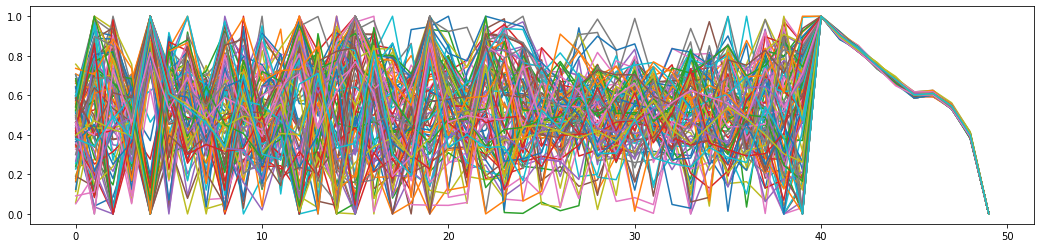

In [ ]:
plt.figure(figsize=(18, 4))
w=plt.plot(pred.iloc[:,0:100])#.iloc[0:42,0:9])
# w=plt.plot(pred_list.iloc[:,1:cc])
# w=plt.plot(t2data[:,10:20])

In [ ]:
trainScore = math.sqrt(mean_squared_error(t2data[30:40], pred_list))
print('Train Score: %.2f RMSE' % (trainScore))


Train Score: 0.38 RMSE
